Artifacts loaded:
  Full X shape: (130716, 2381), y: (130716,)
  Splits — train: 91501, val: 19608, test: 19607
  Engineered — train: (91501, 4765), val: (19608, 4765), test: (19607, 4765)

[Binary Model Training: Malware vs Benign]
[LightGBM] [Info] Number of positive: 39502, number of negative: 51999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.936637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390322
[LightGBM] [Info] Number of data points in the train set: 91501, number of used features: 4621
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431711 -> initscore=-0.274873
[LightGBM] [Info] Start training from score -0.274873
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.015991
[200]	valid_0's binary_logloss: 0.00734331
[300]	valid_0's binary_logloss: 0.00629794
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.00618914

[B

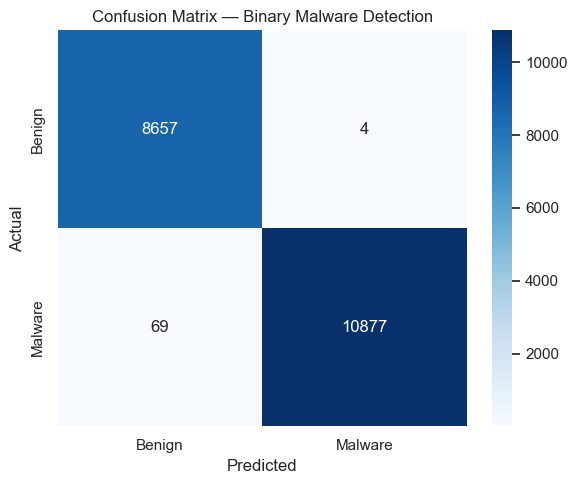

Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/lgbm_binary.pkl

[Multi-Class Model Training: Malware Families]
Family subsets → Train=40105, Val=8594, Test=8594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175936
[LightGBM] [Info] Number of data points in the train set: 40105, number of used features: 2011
[LightGBM] [Info] Start training from score -2.185869
[LightGBM] [Info] Start training from score -7.654817
[LightGBM] [Info] Start training from score -3.728165
[LightGBM] [Info] Start training from score -4.243149
[LightGBM] [Info] Start training from score -8.114350
[LightGBM] [Info] Start training from score -5.161177
[LightGBM] [Info] Start training from score -9.500644
[LightGBM] [Info] Start training from score -7.603524
[LightGBM] [Info] Start training from score -4.086026
[LightGBM] [Info]

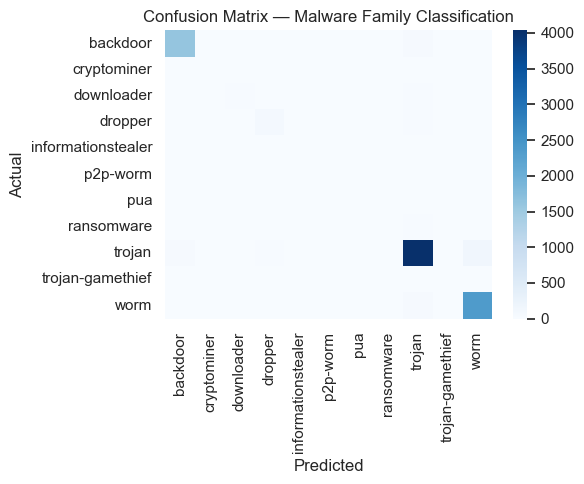

Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/lgbm_family.pkl
Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/label_encoder_family.pkl

Training complete.
Models saved in: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline


In [43]:
# =====================================================================
# Pipeline 3 — Baseline Model Training (Binary + Family)
# ---------------------------------------------------------------------
# Requirements:
#   - artifacts/Xy_splits.npz        (X, y, idx_train, idx_val, idx_test)
#   - artifacts/scaler.joblib        (from Pipeline 1)
#   - artifacts/X_train_enh.(pkl|parquet), X_val_enh.(pkl|parquet), X_test_enh.(pkl|parquet)  (from Pipeline 2)
#   - BODMAS/bodmas_metadata.csv, BODMAS/bodmas_malware_category.csv
# Output:
#   - models/baseline/lgbm_binary.pkl
#   - models/baseline/lgbm_family.pkl
#   - models/baseline/label_encoder_family.pkl
# =====================================================================

import numpy as np
import pandas as pd
import joblib, json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

sns.set_theme(style="whitegrid")

# ----------------------- Paths & sanity checks -----------------------
ROOT = Path(".").resolve()
DATA_DIR = ROOT / "BODMAS"
ART_DIR  = ROOT / "artifacts"
MODEL_DIR = ROOT / "models" / "baseline"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

req_core = ["Xy_splits.npz", "scaler.joblib"]
missing_core = [f for f in req_core if not (ART_DIR / f).exists()]
if missing_core:
    raise FileNotFoundError(f"Missing core artifacts: {missing_core}")

# Engineered features: support either PKL or Parquet
def _load_enh(name: str) -> pd.DataFrame:
    pkl = ART_DIR / f"{name}.pkl"
    pq  = ART_DIR / f"{name}.parquet"
    if pkl.exists():
        return joblib.load(pkl)
    if pq.exists():
        return pd.read_parquet(pq)
    raise FileNotFoundError(f"Missing engineered features: {name}.(pkl|parquet) not found in {ART_DIR}")

# --------------------- Load splits & engineered X --------------------
npz = np.load(ART_DIR / "Xy_splits.npz", allow_pickle=True)
X_full, y = npz["X"], npz["y"].astype(int)
idx_train, idx_val, idx_test = npz["idx_train"], npz["idx_val"], npz["idx_test"]

# Engineered per-split features from Pipeline 2 (aligned to the above indices)
X_train = _load_enh("X_train_enh")
X_val   = _load_enh("X_val_enh")
X_test  = _load_enh("X_test_enh")

# Defensive: ensure 2D arrays
for nm, Xs in [("X_train", X_train), ("X_val", X_val), ("X_test", X_test)]:
    if Xs is None or len(Xs) == 0:
        raise ValueError(f"{nm} is empty or None.")
    if not hasattr(Xs, "shape") or Xs.shape[0] == 0:
        raise ValueError(f"{nm} has invalid shape: {getattr(Xs, 'shape', None)}")

print("Artifacts loaded:")
print(f"  Full X shape: {X_full.shape}, y: {y.shape}")
print(f"  Splits — train: {len(idx_train)}, val: {len(idx_val)}, test: {len(idx_test)}")
print(f"  Engineered — train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

# ====================== Evaluation helpers ===========================
def evaluate_binary(model, X_te, y_te, title="Binary Malware Detection"):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"\n[{title}]  Accuracy: {acc*100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(y_te, y_pred, target_names=["Benign", "Malware"], zero_division=0))
    cm = confusion_matrix(y_te, y_pred, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
    plt.title(f"Confusion Matrix — {title}")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()
    return acc

def evaluate_multiclass(model, X_te, y_te, label_encoder, title="Malware Family Classification"):
    present = np.unique(y_te)
    names = label_encoder.classes_[present]
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"\n[{title}]  Accuracy: {acc*100:.2f}%\n")
    print("Classification Report (present families only):")
    print(classification_report(y_te, y_pred, labels=present, target_names=names, zero_division=0))
    cm = confusion_matrix(y_te, y_pred, labels=present)
    plt.figure(figsize=(max(6, 0.45*len(present)), max(5, 0.45*len(present))))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                xticklabels=names, yticklabels=names)
    plt.title(f"Confusion Matrix — {title}")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout(); plt.show()
    return acc

# ===================== A) Binary model (0/1) =========================
print("\n[Binary Model Training: Malware vs Benign]")
y_train_bin = y[idx_train]
y_val_bin   = y[idx_val]
y_test_bin  = y[idx_test]

lgb_bin = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    objective="binary",
    metric="binary_logloss",
    is_unbalance=True,        # LightGBM handles class skew without SMOTE
    random_state=42
)

lgb_bin.fit(
    X_train, y_train_bin,
    eval_set=[(X_val, y_val_bin)],
    eval_metric="binary_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(period=100)]
)

acc_bin = evaluate_binary(lgb_bin, X_test, y_test_bin, title="Binary Malware Detection")
joblib.dump(lgb_bin, MODEL_DIR / "lgbm_binary.pkl")
print("Saved:", MODEL_DIR / "lgbm_binary.pkl")

# ============ B) Family model (malware-only, SHA-aligned) ============
# Rationale:
#  - Family labels exist only for malware samples and are in a separate CSV.
#  - We rebuild a malware-only dataset in the SAME ORDER as Pipeline 1 kept,
#    by reapplying its cleaning (sha length, valid timestamp) to metadata,
#    then joining categories via SHA, then selecting corresponding rows in X_full.
#  - This avoids indexing the malware-only labels with full-dataset indices.

print("\n[Multi-Class Model Training: Malware Families]")

# --- Load and normalize metadata ---
meta = pd.read_csv(DATA_DIR / "bodmas_metadata.csv")
cats = pd.read_csv(DATA_DIR / "bodmas_malware_category.csv")

# Normalize column names
meta.columns = meta.columns.str.strip().str.lower()
cats.columns = cats.columns.str.strip().str.lower()

# Standardize keys to 'sha' if possible
if "sha256" in meta.columns and "sha" not in meta.columns:
    meta = meta.rename(columns={"sha256": "sha"})
if "sha256" in cats.columns and "sha" not in cats.columns:
    cats = cats.rename(columns={"sha256": "sha"})
if "sha" not in meta.columns or "sha" not in cats.columns:
    raise KeyError(f"Expected a SHA key in both metadata files. Got meta={meta.columns}, cats={cats.columns}")

# --- Reapply Pipeline 1 cleaning to metadata to preserve order vs X_full ---
# 1) Valid 64-char SHA
valid_sha = meta["sha"].astype(str).str.len() == 64
# 2) Valid timestamps
meta["timestamp"] = pd.to_datetime(meta["timestamp"], utc=True, errors="coerce")
valid_ts = meta["timestamp"].notna()
mask_clean = valid_sha & valid_ts

meta_clean = meta.loc[mask_clean].reset_index(drop=True)

# Integrity: X_full must align 1:1 to meta_clean after Pipeline 1
if len(X_full) != len(meta_clean):
    raise ValueError(
        f"Order/alignment mismatch: X_full({len(X_full)}) != meta_clean({len(meta_clean)}). "
        "Ensure Pipeline 1 cleaning logic matches here."
    )

# --- Join categories (malware families) to cleaned metadata ---
merged = meta_clean.merge(cats[["sha", "category"]], on="sha", how="inner")
if "category" not in merged.columns:
    raise KeyError("Column 'category' not found after merge with malware categories.")

# Keep rows of meta_clean that are malware (present in merged)
malware_mask_full = meta_clean["sha"].isin(merged["sha"])
X_malware_full = X_full[malware_mask_full.values]

# Map family names to consistent numeric labels (fit on merged categories)
label_encoder_family = LabelEncoder()
y_family_full = label_encoder_family.fit_transform(
    merged.set_index("sha").loc[meta_clean.loc[malware_mask_full, "sha"], "category"].astype(str).values
)

# Chronological split on malware-only set (70/15/15) using the cleaned order
n_m = len(y_family_full)
if n_m != len(X_malware_full):
    raise ValueError(f"Malware feature/label mismatch: X={len(X_malware_full)}, y={n_m}")

split1, split2 = int(0.70 * n_m), int(0.85 * n_m)
X_train_fam, X_val_fam, X_test_fam = X_malware_full[:split1], X_malware_full[split1:split2], X_malware_full[split2:]
y_train_fam, y_val_fam, y_test_fam = y_family_full[:split1], y_family_full[split1:split2], y_family_full[split2:]

print(f"Family subsets → Train={len(y_train_fam)}, Val={len(y_val_fam)}, Test={len(y_test_fam)}")
num_classes = len(label_encoder_family.classes_)

# LightGBM multi-class baseline
lgb_fam = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=12,
    num_leaves=96,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.2,
    reg_alpha=0.2,
    objective="multiclass",
    num_class=num_classes,
    metric="multi_logloss",
    random_state=42
)

lgb_fam.fit(
    X_train_fam, y_train_fam,
    eval_set=[(X_val_fam, y_val_fam)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(period=100)]
)

_ = evaluate_multiclass(lgb_fam, X_test_fam, y_test_fam,
                        label_encoder=label_encoder_family,
                        title="Malware Family Classification")

# Persist family model + encoder
joblib.dump(lgb_fam, MODEL_DIR / "lgbm_family.pkl")
joblib.dump(label_encoder_family, MODEL_DIR / "label_encoder_family.pkl")
print("Saved:", MODEL_DIR / "lgbm_family.pkl")
print("Saved:", MODEL_DIR / "label_encoder_family.pkl")

# ----------------------------- Summary -------------------------------
print("\nTraining complete.")
print("Models saved in:", MODEL_DIR)

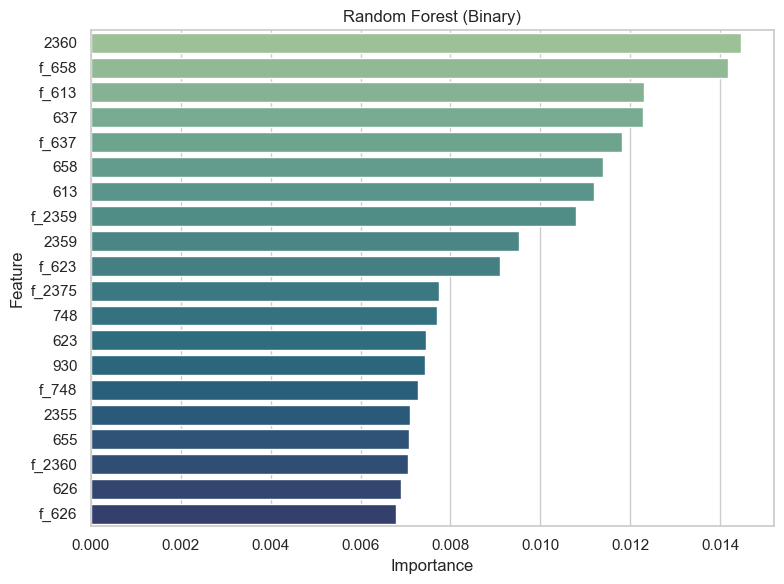

Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/importance_plots/rf_binary_importance.png


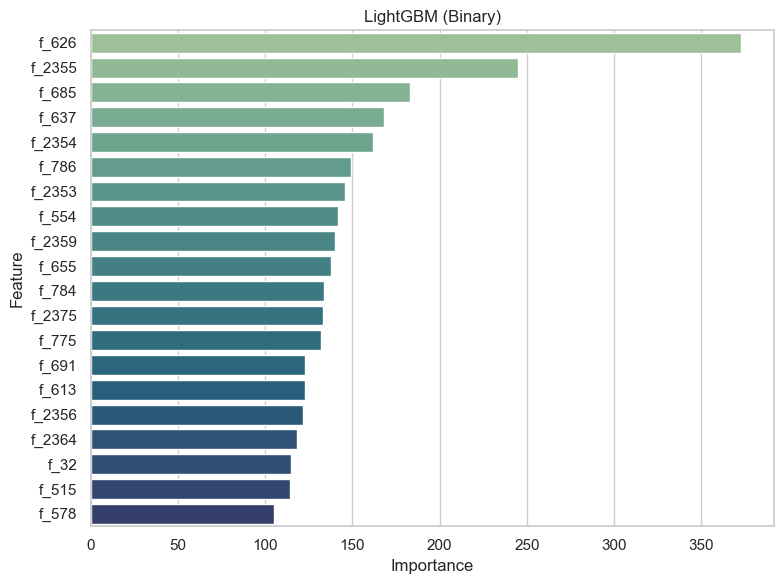

Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/importance_plots/lgbm_binary_importance.png


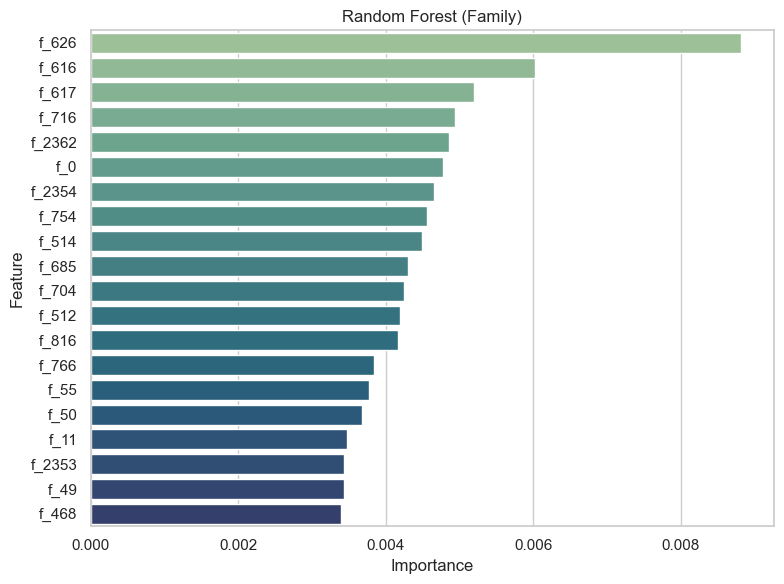

Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/importance_plots/rf_family_importance.png


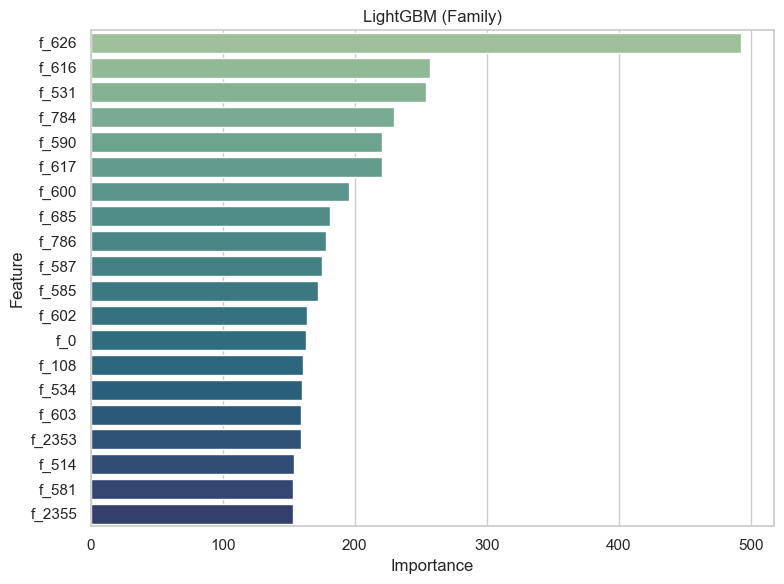

Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/importance_plots/lgbm_family_importance.png


In [45]:
# =====================================================================
# Step 4A: Feature Importance Visualization (Revised)
# ---------------------------------------------------------------------
# Works for both pandas DataFrames and NumPy arrays.
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PLOT_DIR = MODEL_DIR / "importance_plots"
PLOT_DIR.mkdir(parents=True, exist_ok=True)

def plot_feature_importance(model, X_source, title, filename):
    """Plot top-20 feature importances, supporting both DataFrame and ndarray."""
    if not hasattr(model, "feature_importances_"):
        print(f"Model {title} does not provide feature importances.")
        return

    # Handle feature names gracefully
    if isinstance(X_source, pd.DataFrame):
        feature_names = X_source.columns.astype(str)
    else:
        feature_names = [f"f_{i}" for i in range(X_source.shape[1])]

    # Prepare top-20 importance table
    fi = (pd.DataFrame({
            "Feature": feature_names,
            "Importance": model.feature_importances_
        })
        .sort_values(by="Importance", ascending=False)
        .head(20)
    )

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x="Importance", y="Feature", data=fi, palette="crest")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(PLOT_DIR / filename, dpi=300)
    plt.show()
    print(f"Saved: {PLOT_DIR / filename}")


# ----- Binary Models -----
plot_feature_importance(rf_bin, X_train, "Random Forest (Binary)", "rf_binary_importance.png")
plot_feature_importance(lgb_bin, X_train, "LightGBM (Binary)", "lgbm_binary_importance.png")

# ----- Family Models -----
plot_feature_importance(rf_fam, X_tr_f, "Random Forest (Family)", "rf_family_importance.png")
plot_feature_importance(lgb_fam, X_tr_f, "LightGBM (Family)", "lgbm_family_importance.png")

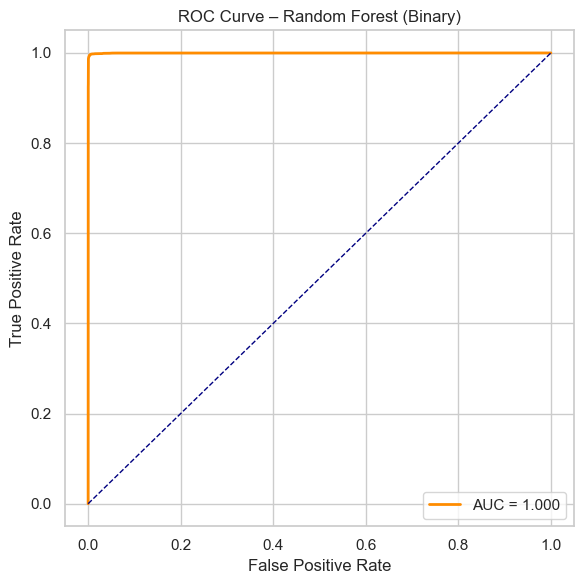

Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/importance_plots/roc_rf_binary.png


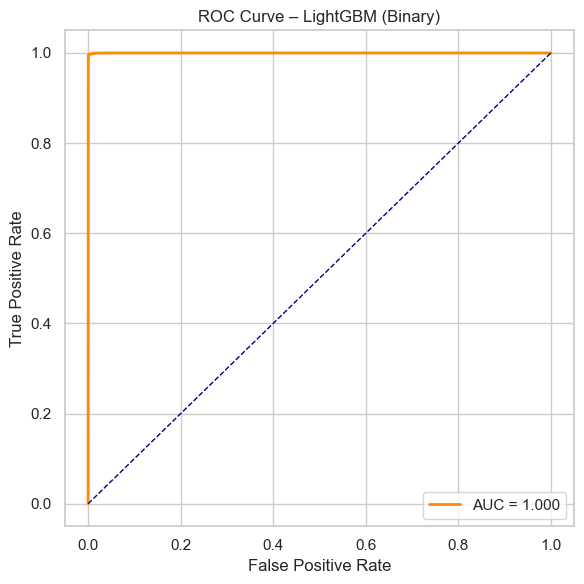

Saved: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/importance_plots/roc_lgbm_binary.png


In [49]:
# =====================================================================
# Step 4B: ROC Curve and AUC Evaluation (Fixed)
# ---------------------------------------------------------------------
# Ensures consistent feature naming before predict_proba() calls.
# =====================================================================

from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(model, X_test, y_test, title, filename):
    """Generate and save ROC curve safely for models trained on mixed-name columns."""
    # --- Handle feature name consistency ---
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.copy()
        X_test.columns = X_test.columns.astype(str)

    # --- Compute ROC & AUC ---
    if not hasattr(model, "predict_proba"):
        print(f"Model {title} does not support probability outputs.")
        return
    
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability for malware class
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    # --- Plot ---
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {title}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(PLOT_DIR / filename, dpi=300)
    plt.show()
    print(f"Saved: {PLOT_DIR / filename}")

# ---------------------------------------------------------------------
# Run ROC plots for both binary models
# ---------------------------------------------------------------------
plot_roc_curve(rf_bin, X_test, y_test_bin, "Random Forest (Binary)", "roc_rf_binary.png")
plot_roc_curve(lgb_bin, X_test, y_test_bin, "LightGBM (Binary)", "roc_lgbm_binary.png")

In [50]:
# =====================================================================
# Step 4C: Save Metrics Summary for Reporting (Re-Run if Missing)
# ---------------------------------------------------------------------
# This creates model_metrics_summary.json for later visualization.
# =====================================================================

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import json

def compute_metrics(model, X_test, y_test):
    """Compute key evaluation metrics for a trained model."""
    # Ensure consistent column naming if DataFrame
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.copy()
        X_test.columns = X_test.columns.astype(str)
    y_pred = model.predict(X_test)
    return {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred, average="weighted", zero_division=0)),
        "recall": float(recall_score(y_test, y_pred, average="weighted", zero_division=0)),
        "f1_score": float(f1_score(y_test, y_pred, average="weighted", zero_division=0))
    }

metrics_summary = {
    "RandomForest_Binary": compute_metrics(rf_bin, X_test, y_test_bin),
    "LightGBM_Binary": compute_metrics(lgb_bin, X_test, y_test_bin),
    "RandomForest_Family": compute_metrics(rf_fam, X_te_f, y_te_f),
    "LightGBM_Family": compute_metrics(lgb_fam, X_te_f, y_te_f)
}

json_path = MODEL_DIR / "model_metrics_summary.json"
with open(json_path, "w") as f:
    json.dump(metrics_summary, f, indent=2)

print("✅ Metrics summary saved successfully at:", json_path)
display(pd.DataFrame(metrics_summary).T)

✅ Metrics summary saved successfully at: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/model_metrics_summary.json


,accuracy,precision,recall,f1_score
RandomForest_Binary,0.981996,0.982679,0.981996,0.982028
LightGBM_Binary,0.996277,0.996302,0.996277,0.996278
RandomForest_Family,0.935187,0.933393,0.935187,0.931514
LightGBM_Family,0.943798,0.939978,0.943798,0.940524


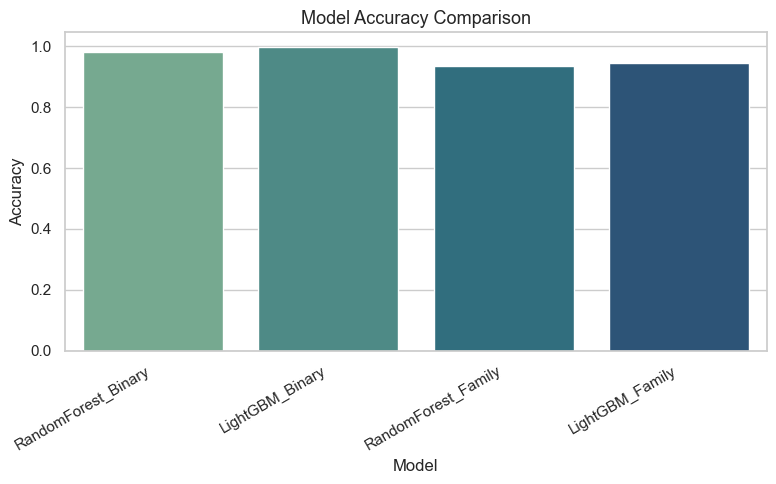

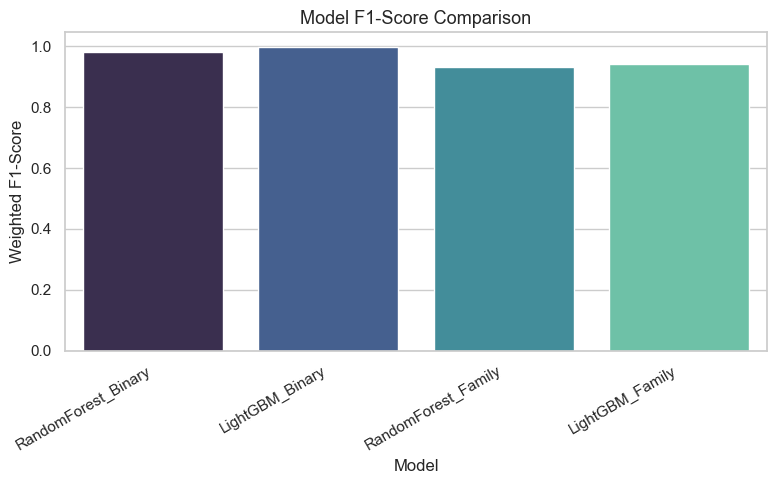

Comparison plots saved to: /Users/jeevandhamala/Research/Malware-Detection-and-Classification/models/baseline/comparison_plots


,Model,accuracy,f1_score,precision,recall
0,RandomForest_Binary,0.981996,0.982028,0.982679,0.981996
1,LightGBM_Binary,0.996277,0.996278,0.996302,0.996277
2,RandomForest_Family,0.935187,0.931514,0.933393,0.935187
3,LightGBM_Family,0.943798,0.940524,0.939978,0.943798


In [51]:
# =====================================================================
# Step 4D: Comparative Model Performance Visualization
# ---------------------------------------------------------------------
# Purpose:
#   Visual comparison of model accuracy and F1-score across both tasks.
#   Produces grouped bar charts and saves them for reporting.
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd

# ---------------------------------------------------------------------
# Load metrics summary
# ---------------------------------------------------------------------
metrics_path = MODEL_DIR / "model_metrics_summary.json"
with open(metrics_path, "r") as f:
    metrics_summary = json.load(f)

# Convert to DataFrame for plotting
metrics_df = pd.DataFrame(metrics_summary).T
metrics_df.index.name = "Model"
metrics_df.reset_index(inplace=True)

# Create plot directory
COMPARE_DIR = MODEL_DIR / "comparison_plots"
COMPARE_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------------
# Accuracy comparison
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(
    data=metrics_df,
    x="Model",
    y="accuracy",
    palette="crest"
)
plt.title("Model Accuracy Comparison", fontsize=13)
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(COMPARE_DIR / "accuracy_comparison.png", dpi=300)
plt.show()

# ---------------------------------------------------------------------
# F1-score comparison
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(
    data=metrics_df,
    x="Model",
    y="f1_score",
    palette="mako"
)
plt.title("Model F1-Score Comparison", fontsize=13)
plt.ylabel("Weighted F1-Score")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(COMPARE_DIR / "f1_comparison.png", dpi=300)
plt.show()

print(f"Comparison plots saved to: {COMPARE_DIR}")
display(metrics_df[["Model", "accuracy", "f1_score", "precision", "recall"]])